## Finding
* 2019 misses data on_1b, on_2b, and on_3b
* incorrect ball and strike counts in 2019
* 2019 data can't be used
* Use TimeSeriesSplit (iterators) can be used in cv=
* RF => set max_depth

## EDA
* More balls less fastball 'b_count'
* 2 strikes less fastball 's_2'
* Out no effect
* tie=> more fastball; ahead/behind => less fastball 'ahead' 'behind'
* Left Batter => more fastball
* Warm => less fastball
* Last play Error => less fastball
* Last play Out => more fastball
* Last play Homerun/Triple/Douple => less fastball 'last_pa_homerun' 'last_pa_double_triple'
* Last Pitch result 'last_pitch'
* Last pitch type/fastball => less fastball
* More innings less fastball
* on_1b no effect
* last play pitch a lot => fastball

## Completed
* Data assembling
* SQL database
* Data Cleaning
* EDA

## To do
* split
* modeling



In [1]:
import pandas as pd
import numpy as np

In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
#from sklearn.ensemble import StackingClassifier
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from mlxtend.classifier import StackingClassifier
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [281]:
# feature engineering
# type_confidence, code 
df = pd.read_sql("""SELECT pitch_type, start_speed, zone, code, type, b_score, p_score, ab_id, pitch_num,
                    b_count, s_count, outs, on_1b, on_2b, on_3b, event, inning, stand, top, 
                    weather, start_time, year                    
                    FROM scherzer
                    WHERE year != 2019;""",'sqlite:///mlb_2015_2019.db')

In [282]:
#df['xxxx'] = df['xxxx'].apply(lambda x: 'xx' if x == 'xx' else 'xx')
df['top'].replace(['FALSE','TRUE'],[0,1],inplace=True)
df['top'] = df['top'].astype('int')
df['stand'].replace(['R','L'],[0,1],inplace=True)
df.rename(columns={"stand": "left_batter"},inplace=True)
df['start_time'] = pd.to_timedelta(df['start_time']+':00')
df['day_game'] = (df['start_time'] < '16:30:00').astype('int')
#df['fastball'] = df['pitch_type'].isin(['FF','FT','FC']).astype('int')
df.insert(1, column='fastball', value = df['pitch_type'].isin(['FF','FT','FC']).astype('int'))
df = pd.concat([df,pd.get_dummies(df['b_count'],prefix='b',drop_first=False)], axis=1)
df = pd.concat([df,pd.get_dummies(df['s_count'],prefix='s',drop_first=False)], axis=1)
df = pd.concat([df,pd.get_dummies(df['outs'],prefix='o',drop_first=False)], axis=1)
df['s_over_b'] = (df['s_count'] > df['b_count']).astype('int')
df['b_over_s'] = (df['s_count'] < df['b_count']).astype('int')
df['on_2b3b'] =  ((df['on_2b'] ==1) | (df['on_3b'] ==1)).astype('int')
df['inning_sq_root'] =  df['inning'] ** (1/2)
df['after_4_inning'] =  (df['inning'] > 3).astype('int')
df['after_5_inning'] =  (df['inning'] > 4).astype('int')
df['firstball'] = (df['pitch_num'] == 1).astype('int')
df['first2ball'] = (df['pitch_num'] < 3).astype('int')
df['abs_diff'] = abs(df['p_score'] - df['b_score'])
df['diff'] = df['p_score'] - df['b_score']
df['tie'] = (df['p_score'] == df['b_score']).astype('int')
df['ahead'] = (df['p_score'] - df['b_score'] > 0).astype('int')
df['behind'] = (df['p_score'] - df['b_score'] < 0).astype('int')
df['tempature'] = df['weather'].apply(lambda x : x[:2]).astype('int') #min 45 max 95
df['more_than_70'] = (df['tempature'] > 70).astype('int')
df['last_pitch_type'] = df['pitch_type'].shift(1)
df.loc[0,'last_pitch_type'] = 'FF'
df['last_fastball'] = df['fastball'].shift(1)
df.loc[0,'last_fastball'] = 1
df['last_fastball'] = df['last_fastball'].astype('int')
df['last_code'] = df['code'].shift(1)
df.loc[0,'last_code'] = 'X'
df['last_type'] = df['type'].shift(1)
df.loc[0,'last_type'] = 'X'
df['last_b'] = df['last_type'].isin(['B']).astype('int')
df['last_s'] = df['last_type'].isin(['S']).astype('int')
df['last_inplay'] = df['last_type'].isin(['X']).astype('int')
df['last_contact'] = df['last_code'].isin(['F','T','L','R','X','D','E']).astype('int')
df['last_pitch'] = df['last_code'].map({'B':'B','*B':'B','S':'S','C':'S','F':'S','T':'S','L':'S',
                                       'I':'B','W':'S','M':'S','P':'B','Q':'S','R':'S','X':'X',
                                       'D':'H','E':'R','H':'B','V':'B'})
df['last_run'] = df['last_pitch'].isin(['R']).astype('int')
df['last_in_play_out'] = df['last_pitch'].isin(['R']).astype('int')
df_pa = pd.read_csv('data/atbats.csv')
df_pa['last_pa'] = df_pa['event'].shift(1)
df_pa.loc[0,'last_pa'] = 'Strikeout'
df_pa = pd.merge(df_pa[df_pa['pitcher_id'] ==453286], 
                 df.drop_duplicates(subset=['ab_id'], keep='last')[['pitch_num','ab_id']]
                 , on = 'ab_id')
df_pa['last_num'] = df_pa['pitch_num'].shift(1)
df_pa.loc[0,'last_num'] = 4 #mean
df_pa['last_num'] = df_pa['last_num'].astype('int')
df_pa['game_pitch'] = df_pa.groupby(['g_id']).cumsum().reset_index()['last_num'] - 4
df = pd.merge(df ,df_pa[['ab_id','last_pa','last_num','game_pitch']], on = 'ab_id')
df['last_over_9'] = (df['last_num'] > 9).astype('int')
df['over_30_pitches'] = (df['game_pitch'] > 30).astype('int')
df['last_pa_homerun'] = df['last_pa'].isin(['Home Run']).astype('int')
df['last_pa_double_triple'] = df['last_pa'].isin(['Double','Triple']).astype('int')
df['last_pa_long'] = df['last_pa'].isin(['Double','Triple','Home Run']).astype('int')
df['last_pa_so'] = df['last_pa'].isin(['Strikeout']).astype('int')
df['last_pa_bb'] = df['last_pa'].isin(['Walk','Hit By Pitch','Intent Walk']).astype('int')
df['last_pa_dp'] = df['last_pa'].isin(['Grounded Into DP','Double Play','Strikeout - DP','Sac Fly DP',
                                      'Sacrifice Bunt DP']).astype('int')
df['last_pa_out'] = df['last_pa'].isin(['Strikeout','Groundout','Flyout','Lineout','Pop Out','Forceout',
                                        'Runner Out','Bunt Groundout','Fielders Choice Out','Bunt Pop Out',
                                        'Fielders Choice','Batter Interference','Bunt Lineout',
                                        'Grounded Into DP','Double Play','Strikeout - DP','Sac Fly DP',
                                        'Sacrifice Bunt DP']).astype('int')


#df.to_csv('data/scherzer_features.csv')

In [6]:
#******must Run***
#Split
tscv = TimeSeriesSplit(n_splits=5)
df_clean = df.dropna(how='any')
for train_index, test_index in tscv.split(df_clean):
    df_train, df_test = df_clean.iloc[train_index,], df_clean.iloc[test_index]
#df_train.to_csv('data/scherzer_train.csv')

In [7]:
#******must Run***
scaler = StandardScaler()
df_train_scaled = df_train.drop(['pitch_type', 'start_speed', 'zone', 'code', 'type',
                                 'ab_id','event','weather','start_time', 'year','last_pitch_type','last_code',
                                 'last_type', 'last_pitch', 'last_pa'], axis=1)
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train_scaled))
df_train_scaled.columns = df_train.drop(['pitch_type', 'start_speed', 'zone', 'code', 'type',
                                         'ab_id','event','weather','start_time', 'year','last_pitch_type',
                                         'last_code','last_type', 'last_pitch', 'last_pa'], axis=1).columns
df_train_scaled.fastball = (df_train_scaled.fastball > 0).astype('int')
df_train_scaled

,fastball,b_score,p_score,pitch_num,b_count,s_count,outs,on_1b,on_2b,on_3b,...,game_pitch,last_over_9,over_30_pitches,last_pa_homerun,last_pa_double_triple,last_pa_long,last_pa_so,last_pa_bb,last_pa_dp,last_pa_out
0,1,-0.733481,-0.803790,-1.092809,-0.848763,-1.153150,-1.231507,-0.540924,-0.380042,-0.243793,...,-1.624762,-0.076362,-1.473064,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149
1,1,-0.733481,-0.803790,-0.520526,-0.848763,0.037815,-1.231507,-0.540924,-0.380042,-0.243793,...,-1.624762,-0.076362,-1.473064,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149
2,1,-0.733481,-0.803790,0.051757,-0.848763,1.228780,-1.231507,-0.540924,-0.380042,-0.243793,...,-1.624762,-0.076362,-1.473064,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149
3,0,-0.733481,-0.803790,0.624040,0.236709,1.228780,-1.231507,-0.540924,-0.380042,-0.243793,...,-1.624762,-0.076362,-1.473064,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149
4,1,-0.733481,-0.803790,1.196323,1.322180,1.228780,-1.231507,-0.540924,-0.380042,-0.243793,...,-1.624762,-0.076362,-1.473064,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11207,0,-0.733481,-0.366713,-0.520526,0.236709,-1.153150,1.237673,-0.540924,-0.380042,-0.243793,...,0.614589,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149
11208,1,-0.733481,-0.366713,0.051757,0.236709,0.037815,1.237673,-0.540924,-0.380042,-0.243793,...,0.614589,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149
11209,0,-0.733481,-0.366713,0.624040,0.236709,1.228780,1.237673,-0.540924,-0.380042,-0.243793,...,0.614589,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149
11210,1,-0.733481,-0.366713,1.196323,1.322180,1.228780,1.237673,-0.540924,-0.380042,-0.243793,...,0.614589,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149


In [8]:
#******must Run*** for test
df_test_scaled = df_test.drop(['pitch_type', 'start_speed', 'zone', 'code', 'type',
                               'ab_id','event','weather','start_time', 'year','last_pitch_type','last_code',
                               'last_type', 'last_pitch', 'last_pa'], axis=1)
df_test_scaled = pd.DataFrame(scaler.transform(df_test_scaled))
df_test_scaled.columns = df_train.drop(['pitch_type', 'start_speed', 'zone', 'code', 'type',
                                        'ab_id','event','weather','start_time', 'year','last_pitch_type',
                                        'last_code','last_type', 'last_pitch', 'last_pa'], axis=1).columns
df_test_scaled.fastball = (df_test_scaled.fastball > 0).astype('int')
df_test_scaled


,fastball,b_score,p_score,pitch_num,b_count,s_count,outs,on_1b,on_2b,on_3b,...,game_pitch,last_over_9,over_30_pitches,last_pa_homerun,last_pa_double_triple,last_pa_long,last_pa_so,last_pa_bb,last_pa_dp,last_pa_out
0,1,-0.733481,-0.366713,-0.520526,-0.848763,0.037815,-1.231507,-0.540924,-0.380042,-0.243793,...,0.776861,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149
1,1,-0.733481,-0.366713,0.051757,0.236709,0.037815,-1.231507,-0.540924,-0.380042,-0.243793,...,0.776861,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149
2,1,-0.733481,-0.366713,-1.092809,-0.848763,-1.153150,0.003083,-0.540924,-0.380042,-0.243793,...,0.874224,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149
3,1,-0.733481,-0.366713,-1.092809,-0.848763,-1.153150,1.237673,-0.540924,-0.380042,-0.243793,...,0.906679,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149
4,0,-0.733481,-0.366713,-0.520526,0.236709,-1.153150,1.237673,-0.540924,-0.380042,-0.243793,...,0.906679,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,-0.664874,-0.259816,-0.143752,0.568149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,1,0.101845,0.507441,2.913172,2.407652,1.228780,0.003083,-0.540924,-0.380042,-0.243793,...,1.166314,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149
2238,1,0.101845,0.507441,3.485455,2.407652,1.228780,0.003083,-0.540924,-0.380042,-0.243793,...,1.166314,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149
2239,0,0.101845,0.507441,4.057738,2.407652,1.228780,0.003083,-0.540924,-0.380042,-0.243793,...,1.166314,-0.076362,0.678857,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149
2240,1,0.101845,0.507441,-1.092809,-0.848763,-1.153150,1.237673,-0.540924,-0.380042,-0.243793,...,1.490858,13.095507,0.678857,-0.166659,-0.224287,-0.284583,1.504044,-0.259816,-0.143752,0.568149


In [9]:
df_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11212 entries, 0 to 11211
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fastball               11212 non-null  int64  
 1   b_score                11212 non-null  float64
 2   p_score                11212 non-null  float64
 3   pitch_num              11212 non-null  float64
 4   b_count                11212 non-null  float64
 5   s_count                11212 non-null  float64
 6   outs                   11212 non-null  float64
 7   on_1b                  11212 non-null  float64
 8   on_2b                  11212 non-null  float64
 9   on_3b                  11212 non-null  float64
 10  inning                 11212 non-null  float64
 11  left_batter            11212 non-null  float64
 12  top                    11212 non-null  float64
 13  day_game               11212 non-null  float64
 14  b_0                    11212 non-null  float64
 15  b_

In [908]:
sns.pairplot(df_train_scaled, hue='fastball')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa334be0670> (for post_execute):


KeyboardInterrupt: 

## Baseline Model

In [361]:
X = df_train[['b_count', 's_count', 'outs', 'on_1b', 'on_2b','on_3b','inning', 'left_batter', 'top','day_game']]
y = df_train['fastball']

In [362]:
#y.mean()
metrics.accuracy_score(y, [1]*len(y))

0.5871387798787014

In [363]:
dummy_cv = []
for train_index, test_index in tscv.split(X):
    dummy_cv.append(y.iloc[test_index].mean())
print(dummy_cv)
np.mean(dummy_cv)

[0.6193790149892934, 0.5701284796573876, 0.5722698072805139, 0.5519271948608137, 0.6145610278372591]


0.5856531049250535

In [364]:
log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.6027470567249376

In [365]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.658913
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11201
Method:                           MLE   Df Model:                           10
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                 0.02798
Time:                        14:05:14   Log-Likelihood:                -7387.7
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                 3.697e-85
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5856      0.064      9.102      0.000       0.460       0.712
b_count         0.1990      0.023      8.501      0.000       0.153       0.245
s_count        -0.3217      0.025    -12.668      0.000      -0.371      -0.272
outs            0.0020      0.025      0.079      0.937      -0.047       0.051
on_1b           0.0152      0.048      0.317      0.751      -0.079       0.109
on_2b          -0.1884      0.060     -3.167      0.002      -0.305      -0.072
on_3b          -0.1338      0.086     -1.557      0.119      -0.302       0.035
inning         -0.0746      0.009     -7.997      0.000      -0.093      -0.056
left_batter     0.4361      0.039     11.079      0.000       0.359       0.513
top             0.0026      0.039      0.066      0.948      -0.074       0.079
day_game        0.0624      0.042      1.499      0.134      -0.019       0.144
===============================================================================
"""

In [367]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.5950749464668095 [0.60599572 0.59475375 0.59154176 0.56852248 0.61456103]


## Feature Selection

In [280]:
df_train_scaled.columns

Index(['fastball', 'b_score', 'p_score', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'inning', 'left_batter', 'top',
       'day_game', 'b_0', 'b_1', 'b_2', 'b_3', 's_0', 's_1', 's_2', 'o_0',
       'o_1', 'o_2', 'inning_sq_root', 'after_4_inning', 'after_5_inning',
       'first2ball', 'abs_diff', 'diff', 'tie', 'ahead', 'behind', 'tempature',
       'more_than_70', 'last_fastball', 'last_b', 'last_s', 'last_inplay',
       'last_contact', 'last_run', 'last_num', 'game_pitch', 'last_over_9',
       'over_30_pitches', 'last_pa_homerun', 'last_pa_double_triple',
       'last_pa_long', 'last_pa_so', 'last_pa_bb', 'last_pa_dp',
       'last_pa_out'],
      dtype='object')

In [281]:
X = df_train_scaled[['b_score', 'p_score', 'pitch_num', 'b_count', 's_count',
                     'outs', 'on_1b', 'on_2b', 'on_3b', 'inning', 'left_batter', 'top',
                     'day_game', 'b_0', 'b_1', 'b_2', 'b_3', 's_0', 's_1', 's_2', 'o_0',
                     'o_1', 'o_2', 'after_4_inning', 'after_5_inning', 'first2ball',
                     'abs_diff', 'diff', 'tie', 'ahead', 'behind', 'tempature',
                     'more_than_70', 'last_fastball', 'last_b', 'last_s', 'last_inplay',
                     'last_contact', 'last_num', 'game_pitch', 'last_over_9','last_run',
                     'over_30_pitches', 'last_pa_homerun', 'last_pa_double_triple',
                     'last_pa_long', 'last_pa_so', 'last_pa_bb', 'last_pa_dp',
                     'last_pa_out']]
y = df_train_scaled['fastball']

In [282]:
log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.6189796646450232

In [283]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

         Current function value: 0.649831
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11171
Method:                           MLE   Df Model:                           40
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                 0.04138
Time:                        15:13:48   Log-Likelihood:                -7285.9
converged:                      False   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                6.364e-107
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3732      0.020     18.835      0.000       0.334       0.412
b_score                  -0.0128   9.73e+05  -1.31e-08      1.000   -1.91e+06    1.91e+06
p_score                   0.0766    2.2e+06   3.48e-08      1.000   -4.31e+06    4.31e+06
pitch_num                -0.1630      0.078     -2.101      0.036      -0.315      -0.011
b_count                   0.1597   1.32e+06   1.21e-07      1.000   -2.58e+06    2.58e+06
s_count                  -0.0995   3.71e+05  -2.68e-07      1.000   -7.27e+05    7.27e+05
outs                      0.0029   8.37e+05   3.44e-09      1.000   -1.64e+06    1.64e+06
on_1b                    -0.0054      0.030     -0.183      0.854      -0.063       0.053
on_2b                    -0.0775      0.024     -3.183      0.001      -0.125      -0.030
on_3b                    -0.0319      0.021     -1.551      0.121      -0.072       0.008
inning                   -0.0614      0.081     -0.759      0.448      -0.220       0.097
left_batter               0.2351      0.020     11.729      0.000       0.196       0.274
top                      -0.0023      0.021     -0.105      0.916      -0.044       0.040
day_game                  0.0401      0.020      2.001      0.045       0.001       0.079
b_0                      -0.0908        nan        nan        nan         nan         nan
b_1                      -0.0351        nan        nan        nan         nan         nan
b_2                       0.0583        nan        nan        nan         nan         nan
b_3                       0.1674   3.62e+05   4.63e-07      1.000   -7.09e+05    7.09e+05
s_0                       0.0543        nan        nan        nan         nan         nan
s_1                       0.0684        nan        nan        nan         nan         nan
s_2                      -0.1213        nan        nan        nan         nan         nan
o_0                      -0.0068   8.03e+05  -8.43e-09      1.000   -1.57e+06    1.57e+06
o_1                       0.0085        nan        nan        nan         nan         nan
o_2                      -0.0018        nan        nan        nan         nan         nan
after_4_inning           -0.0260      0.040     -0.649      0.517      -0.104       0.053
after_5_inning           -0.0141      0.040     -0.358      0.721      -0.092       0.063
first2ball               -0.0624      0.042     -1.478      0.139      -0.145       0.020
abs_diff                 -0.1056      0.055     -1.931      0.053      -0.213       0.002
diff                      0.0784   1.96e+06      4e-08      1.000   -3.84e+06    3.84e+06
tie                       0.0038   1.12e+06   3.36e-09      1.000    -2.2e+06     2.2e+06
ahead                    -0.0518   1.11e+06  -4.66e-08      1.000   -2.18e+06    2.18e+06
behind                    0.0605   9.95e+05   6.08e-08      1.000   -1.95e+06    1.95e+06
tempature                -0.0139      0.035     -0.393      0.695      -0.083       0.055
m

In [34]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.60406852248394 [0.59689507 0.60438972 0.61027837 0.58190578 0.62687366]


In [284]:
# negative: ''b_count', 's_count','outs','b_score', 'p_score', 'last_pa_so','last_pa_bb','last_run','inning_sq_root',
# negative: 'behind', 'top','inning','last_inplay', 'last_num', 'game_pitch','over_30_pitches','last_pa_out'
# No diff:'tie','pitch_num','day_game', 'after_5_inning','b_0','o_0','s_0','last_s',
#.        'last_pa_double_triple','last_pa_long', 'last_pa_dp','last_over_9',

X = df_train_scaled[['left_batter', 'abs_diff','diff','ahead','on_1b',  'on_2b', 'on_3b', 'last_fastball',
                      'b_1', 'b_2', 'b_3',  's_1', 's_2', 'o_1', 'o_2',  'first2ball', 
                       'after_4_inning',  'last_b','more_than_70','tempature','last_contact',                 
                      'last_pa_homerun']]
y = df_train_scaled['fastball']

In [285]:
log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.6193364252586514

In [286]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.651289
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11188
Method:                           MLE   Df Model:                           23
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                 0.03923
Time:                        15:14:02   Log-Likelihood:                -7302.3
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                2.669e-111
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3721      0.020     18.815      0.000       0.333       0.411
left_batter         0.2293      0.020     11.544      0.000       0.190       0.268
abs_diff           -0.0454      0.030     -1.494      0.135      -0.105       0.014
diff                0.0783      0.036      2.174      0.030       0.008       0.149
ahead              -0.0724      0.030     -2.452      0.014      -0.130      -0.015
on_1b               0.0127      0.020      0.622      0.534      -0.027       0.053
on_2b              -0.0622      0.020     -3.111      0.002      -0.101      -0.023
on_3b              -0.0253      0.020     -1.264      0.206      -0.065       0.014
last_fastball      -0.1546      0.020     -7.664      0.000      -0.194      -0.115
b_1                 0.0678      0.030      2.252      0.024       0.009       0.127
b_2                 0.1648      0.030      5.428      0.000       0.105       0.224
b_3                 0.2510      0.026      9.507      0.000       0.199       0.303
s_1                -0.0933      0.028     -3.372      0.001      -0.147      -0.039
s_2                -0.4110      0.039    -10.517      0.000      -0.488      -0.334
o_1                 0.0152      0.023      0.657      0.511      -0.030       0.061
o_2                -0.0047      0.024     -0.198      0.843      -0.051       0.041
first2ball         -0.0765      0.042     -1.838      0.066      -0.158       0.005
last_over_9         0.0347      0.021      1.635      0.102      -0.007       0.076
after_4_inning     -0.1476      0.022     -6.845      0.000      -0.190      -0.105
last_b             -0.1797      0.030     -5.949      0.000      -0.239      -0.120
more_than_70       -0.0076      0.034     -0.220      0.826      -0.075       0.060
tempature          -0.0263      0.035     -0.756      0.450      -0.094       0.042
last_contact       -0.0767      0.024     -3.134      0.002      -0.125      -0.029
last_pa_homerun    -0.0368      0.020     -1.862      0.063      -0.075       0.002
===================================================================================
"""

In [287]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6122055674518202 [0.61295503 0.60974304 0.62259101 0.58940043 0.62633833]


In [396]:
log_grid = GridSearchCV(log_reg, 
                        param_grid={'C':[0.001,0.01,0.1,1,10,100,1000,10000],'penalty': ['l1','l2','none'],
                                    'solver': ['liblinear']}, cv=tscv, scoring='accuracy')
log_grid.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [397]:
print("Best params: ", log_grid.best_params_)
print("Best estimator: ", log_grid.best_estimator_)
print("Best score: ", log_grid.best_score_)

Best params:  {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=100, solver='liblinear')
Best score:  0.6123126338329764


## best logistic regression features

In [77]:
df_train.columns

Index(['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_0', 'b_1', 'b_2',
       'b_3', 's_0', 's_1', 's_2', 'o_0', 'o_1', 'o_2', 's_over_b', 'b_over_s',
       'on_2b3b', 'inning_sq_root', 'after_4_inning', 'after_5_inning',
       'firstball', 'first2ball', 'abs_diff', 'diff', 'tie', 'ahead', 'behind',
       'tempature', 'more_than_70', 'last_pitch_type', 'last_fastball',
       'last_code', 'last_type', 'last_b', 'last_s', 'last_inplay',
       'last_contact', 'last_pitch', 'last_run', 'last_in_play_out', 'last_pa',
       'last_num', 'game_pitch', 'last_over_9', 'over_30_pitches',
       'last_pa_homerun', 'last_pa_double_triple', 'last_pa_long',
       'last_pa_so', 'last_pa_bb', 'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [258]:
X = df_train[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b', 'ahead',
              's_1', 's_2', 'after_4_inning','last_contact','last_pa_long']]
y = df_train['fastball']

log_reg = LogisticRegression(penalty='none')
log_reg.fit(X,y)
log_reg.score(X,y)

0.6183553335711738

In [259]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.651805
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11196
Method:                           MLE   Df Model:                           15
Date:                Wed, 27 Oct 2021   Pseudo R-squ.:                 0.03847
Time:                        19:07:51   Log-Likelihood:                -7308.0
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                6.112e-115
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0697      0.101     10.595      0.000       0.872       1.268
left_batter        0.4600      0.040     11.563      0.000       0.382       0.538
b_1                0.1184      0.064      1.848      0.065      -0.007       0.244
b_2                0.4791      0.075      6.423      0.000       0.333       0.625
b_3                1.0726      0.104     10.338      0.000       0.869       1.276
last_b            -0.4341      0.066     -6.578      0.000      -0.563      -0.305
last_fastball     -0.3155      0.041     -7.693      0.000      -0.396      -0.235
firstball         -0.3307      0.095     -3.477      0.001      -0.517      -0.144
o_2               -0.0415      0.042     -0.979      0.327      -0.124       0.042
on_3b             -0.1152      0.086     -1.339      0.180      -0.284       0.053
ahead             -0.0614      0.042     -1.456      0.146      -0.144       0.021
s_1               -0.3692      0.082     -4.504      0.000      -0.530      -0.209
s_2               -0.9670      0.081    -11.877      0.000      -1.127      -0.807
after_4_inning    -0.3114      0.043     -7.307      0.000      -0.395      -0.228
last_contact      -0.1283      0.051     -2.521      0.012      -0.228      -0.029
last_pa_long      -0.1604      0.075     -2.147      0.032      -0.307      -0.014
==================================================================================
"""

In [260]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6157387580299786 [0.63115632 0.60438972 0.61830835 0.59261242 0.63222698]


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.

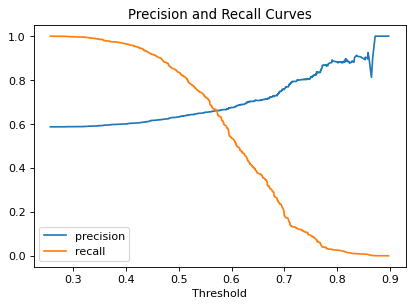

In [192]:
precision_curve, recall_curve, threshold_curve = metrics.precision_recall_curve(y, log_reg.predict_proba(X)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.6283866411999433


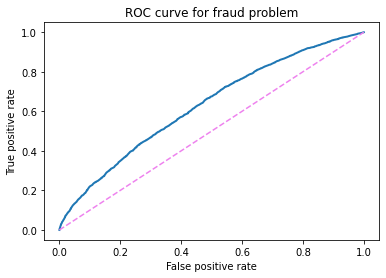

In [193]:
fpr, tpr, thresholds = metrics.roc_curve(y, log_reg.predict_proba(X)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", metrics.roc_auc_score(y, log_reg.predict_proba(X)[:,1]))

In [194]:
metrics.accuracy_score(y, log_reg.predict_proba(X)[:,1]>0.504)

0.6198715661790938

[[1513 3116]
 [1146 5437]]


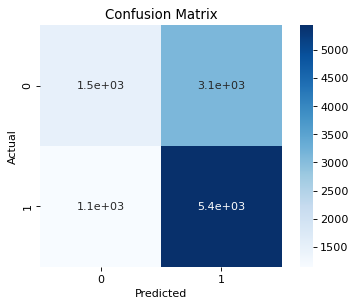

In [197]:
# confusion = metrics.confusion_matrix(y, log_reg.predict(X))
confusion = metrics.confusion_matrix(y, log_reg.predict_proba(X)[:,1] >.504)
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

<AxesSubplot:ylabel='fastball'>

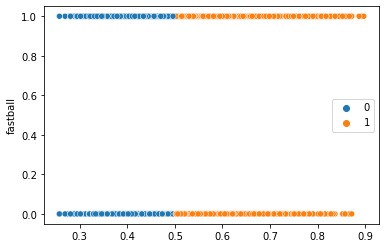

In [196]:
sns.scatterplot(x=log_reg.predict_proba(X)[:,1], y=y , hue=log_reg.predict(X))
#sns.scatterplot(x=log_reg.predict(X), y=y)

In [86]:
metrics.f1_score(y, log_reg.predict(X))

0.720015703723091

In [87]:
metrics.f1_score(y, log_reg.predict_proba(X)[:,1] >.41)

0.7407711720171372

In [107]:
metrics.accuracy_score(y, log_reg.predict_proba(X)[:,1] >.41)

0.606047092400999

In [108]:
metrics.confusion_matrix(y, log_reg.predict_proba(X)[:,1] > 0.41)

array([[ 484, 4145],
       [ 272, 6311]])

In [106]:
for p in np.arange(0.3,0.7,0.01):
    print(p,metrics.f1_score(y, log_reg.predict_proba(X)[:,1] > p))

0.3 0.7397476340694006
0.31 0.7395839206179173
0.32 0.739862193606687
0.33 0.7401869158878505
0.34 0.7397991033426027
0.35000000000000003 0.7401745479436427
0.36000000000000004 0.7401159120904344
0.37000000000000005 0.7404122998963493
0.38000000000000006 0.7409718610966661
0.39000000000000007 0.7407364453464773
0.4000000000000001 0.7400419287211741
0.4100000000000001 0.7407711720171372
0.4200000000000001 0.7397050147492625
0.4300000000000001 0.7382622132414121
0.4400000000000001 0.7371146435452794
0.4500000000000001 0.7373496917536471
0.46000000000000013 0.7350385208012327
0.47000000000000014 0.7317438522032206
0.48000000000000015 0.7282155052485141
0.49000000000000016 0.7240555376170488
0.5000000000000002 0.720015703723091
0.5100000000000002 0.7156170949274397
0.5200000000000002 0.7069659548338677
0.5300000000000002 0.6997291102312981
0.5400000000000003 0.6936784047518031
0.5500000000000003 0.6867608883761177
0.5600000000000003 0.6712115598369766
0.5700000000000003 0.6631395964023883


In [98]:
metrics.confusion_matrix(y, log_reg.predict_proba(X)[:,1] > 0.46)

array([[ 950, 3679],
       [ 620, 5963]])

In [101]:
(950+620)/11212

0.14002854084909025

In [97]:
for p in np.arange(0.3,0.7,0.01):
    mt = metrics.confusion_matrix(y, log_reg.predict_proba(X)[:,1] > p)
    print(p, mt[0,0]/(mt[0,0]+mt[1,0]))


0.3 0.6046511627906976
0.31 0.5862068965517241
0.32 0.6292134831460674
0.33 0.65
0.34 0.6264367816091954
0.35000000000000003 0.6401515151515151
0.36000000000000004 0.6358695652173914
0.37000000000000005 0.6410256410256411
0.38000000000000006 0.6495901639344263
0.39000000000000007 0.6436363636363637
0.4000000000000001 0.6324237560192616
0.4100000000000001 0.6402116402116402
0.4200000000000001 0.6284023668639053
0.4300000000000001 0.6160990712074303
0.4400000000000001 0.6107834877843302
0.4500000000000001 0.6154390934844193
0.46000000000000013 0.6050955414012739
0.47000000000000014 0.5933446136491822
0.48000000000000015 0.5835436648157496
0.49000000000000016 0.577056277056277
0.5000000000000002 0.5696656050955414
0.5100000000000002 0.564370717634331
0.5200000000000002 0.5532186105799872
0.5300000000000002 0.5450264861683343
0.5400000000000003 0.5406515192992062
0.5500000000000003 0.5362872421695951
0.5600000000000003 0.5223255813953488
0.5700000000000003 0.5188431200701139
0.580000000000

In [104]:
for p in np.arange(0.3,0.7,0.01):
    mt = metrics.confusion_matrix(y, log_reg.predict_proba(X)[:,1] > p)
    print(p, mt[1,1]/(mt[0,1]+mt[1,1]))

0.3 0.5878771599964187
0.31 0.5880401649632419
0.32 0.5888699091971591
0.33 0.5901372832369942
0.34 0.5905055263634716
0.35000000000000003 0.5926196565582755
0.36000000000000004 0.5947067502766507
0.37000000000000005 0.596216266345173
0.38000000000000006 0.597911227154047
0.39000000000000007 0.5990433314575127
0.4000000000000001 0.6000566625743696
0.4100000000000001 0.6035768936495792
0.4200000000000001 0.6047072441400598
0.4300000000000001 0.6063653226593771
0.4400000000000001 0.6105735660847881
0.4500000000000001 0.6163265306122448
0.46000000000000013 0.6184401576436424
0.47000000000000014 0.6210403644453861
0.48000000000000015 0.6237677391398548
0.49000000000000016 0.6297461244664121
0.5000000000000002 0.6324137931034483
0.5100000000000002 0.636923806138168
0.5200000000000002 0.6416893732970027
0.5300000000000002 0.6446122344509854
0.5400000000000003 0.6488953565286414
0.5500000000000003 0.653671928620453
0.5600000000000003 0.6552372685185185
0.5700000000000003 0.6598977135980746
0.

## Logistic  - Lasso/Ridge

In [170]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

log_reg = LogisticRegression(C=1, penalty = 'l1', solver='liblinear')
log_reg.fit(X,y)
log_reg.score(X,y)

0.6180877631109526

In [171]:
log_reg.coef_

array([[ 0.22897131,  0.05234994,  0.17078088,  0.25703906, -0.19736271,
        -0.15470148, -0.14060972, -0.01903102, -0.02622966, -0.16402274,
        -0.45248831, -0.15434577, -0.03025908, -0.06101398, -0.0419451 ]])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

In [233]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.651805
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11196
Method:                           MLE   Df Model:                           15
Date:                Wed, 27 Oct 2021   Pseudo R-squ.:                 0.03847
Time:                        15:48:25   Log-Likelihood:                -7308.0
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                6.112e-115
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3713      0.020     18.791      0.000       0.333       0.410
left_batter        0.2293      0.020     11.563      0.000       0.190       0.268
b_1                0.0537      0.029      1.848      0.065      -0.003       0.111
b_2                0.1725      0.027      6.423      0.000       0.120       0.225
b_3                0.2586      0.025     10.338      0.000       0.210       0.308
last_b            -0.2008      0.031     -6.578      0.000      -0.261      -0.141
last_fastball     -0.1554      0.020     -7.693      0.000      -0.195      -0.116
firstball         -0.1442      0.041     -3.477      0.001      -0.225      -0.063
o_2               -0.0195      0.020     -0.979      0.327      -0.058       0.019
on_3b             -0.0265      0.020     -1.339      0.180      -0.065       0.012
s_1               -0.1682      0.037     -4.504      0.000      -0.241      -0.095
s_2               -0.4571      0.038    -11.877      0.000      -0.533      -0.382
after_4_inning    -0.1547      0.021     -7.307      0.000      -0.196      -0.113
ahead             -0.0306      0.021     -1.456      0.146      -0.072       0.011
last_contact      -0.0619      0.025     -2.521      0.012      -0.110      -0.014
last_pa_long      -0.0422      0.020     -2.147      0.032      -0.081      -0.004
==================================================================================
"""

In [864]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6160599571734476 [0.63062099 0.60492505 0.61884368 0.59261242 0.63329764]


In [865]:
metrics.precision_recall_curve(y, log_reg.predict_proba(X)[:,1])

(array([0.58713878, 0.58720671, 0.58722227, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99848094e-01, 9.99696187e-01, ...,
        3.03812851e-04, 1.51906426e-04, 0.00000000e+00]),
 array([0.25829429, 0.27008637, 0.27609528, ..., 0.88653574, 0.89249678,
        0.89632811]))

In [866]:
log_grid = GridSearchCV(log_reg, 
                        param_grid={'C':[0.001,0.01,0.1,1,10,100,1000,10000],'penalty': ['l1','l2','none'],
                                    'solver': ['liblinear']}, cv=tscv, scoring='accuracy')
log_grid.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(C=1, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [867]:
print("Best params: ", log_grid.best_params_)
print("Best estimator: ", log_grid.best_estimator_)
print("Best score: ", log_grid.best_score_)

Best params:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=1, penalty='l1', solver='liblinear')
Best score:  0.6160599571734476


ROC AUC score =  0.6283278672944941


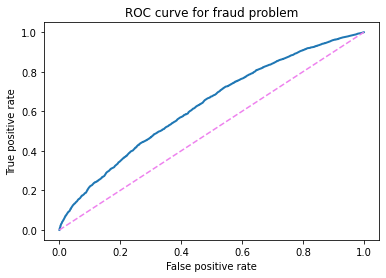

In [868]:
fpr, tpr, thresholds = metrics.roc_curve(y, log_reg.predict_proba(X)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", metrics.roc_auc_score(y, log_reg.predict_proba(X)[:,1]))

[[1427 3202]
 [1080 5503]]


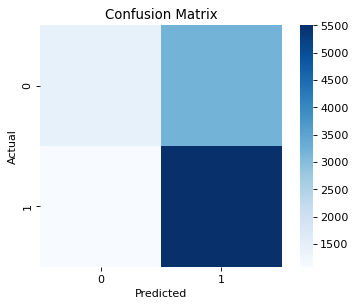

In [870]:
confusion = metrics.confusion_matrix(y, log_reg.predict(X))
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=False, square=True,)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

## KNN - Best features in logistic

In [774]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

In [775]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
metrics.accuracy_score(y, knn.predict(X))

0.6135390652871923

In [776]:
cv_score =  cross_val_score(knn, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(),cv_score)

0.5542826552462528 [0.56316916 0.56852248 0.52944325 0.54229122 0.56798715]


In [740]:
knn = KNeighborsClassifier(n_neighbors=84)
knn.fit(X, y)
metrics.accuracy_score(y, knn.predict(X))

0.627185158758473

In [741]:
cv_score =  cross_val_score(knn, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(),cv_score)

0.606745182012848 [0.624197   0.59850107 0.61616702 0.58458244 0.61027837]


In [664]:
knn_grid = GridSearchCV(knn, dict(n_neighbors=list(range(1, 100)), 
                        weights=['uniform', 'distance']), cv=tscv, scoring='accuracy',n_jobs = -2)

In [665]:
knn_grid.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(n_neighbors=84), n_jobs=-2,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

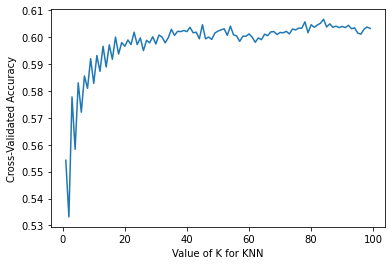

In [666]:
plt.plot(list(range(1, 100)),
         pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');

In [667]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)

Best params:  {'n_neighbors': 84, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=84)
Best score:  0.606745182012848


## KNN-different features

In [442]:
df_train_scaled.columns

Index(['fastball', 'b_score', 'p_score', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'inning', 'left_batter', 'top',
       'day_game', 'b_0', 'b_1', 'b_2', 'b_3', 's_0', 's_1', 's_2', 'o_0',
       'o_1', 'o_2', 'inning_sq_root', 'after_4_inning', 'after_5_inning',
       'firstball', 'first2ball', 'abs_diff', 'diff', 'tie', 'ahead', 'behind',
       'tempature', 'more_than_70', 'last_fastball', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_run', 'last_in_play_out',
       'last_num', 'game_pitch', 'last_over_9', 'over_30_pitches',
       'last_pa_homerun', 'last_pa_double_triple', 'last_pa_long',
       'last_pa_so', 'last_pa_bb', 'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [452]:
#'tempature','more_than_70','last_pa_out','last_pa_long',  'last_num', 'last_run', 'tie', 'abs_diff',
# 'after_5_inning', 'outs', 'b_count', 'b_score','pitch_num','last_in_play_out',

X = df_train_scaled[[ 'p_score', 's_count',
       'on_1b', 'on_2b', 'on_3b', 'inning', 'left_batter', 'top',
       'day_game', 'b_0', 'b_1', 'b_2', 'b_3', 's_0', 's_1', 's_2', 'o_0',
       'o_1', 'o_2', 'after_4_inning', 'first2ball',
       'diff','ahead', 'behind', 
       'last_fastball', 'last_b', 'last_s', 'last_inplay',
       'last_contact', 'game_pitch', 'last_over_9',
       'over_30_pitches', 'last_pa_homerun', 'last_pa_double_triple',
       'last_pa_so', 'last_pa_bb', 'last_pa_dp']]
y = df_train_scaled['fastball']

In [815]:
X = df_train_scaled[['left_batter', 's_1', 's_2','b_1', 'b_2', 'b_3', 'ahead','last_in_play_out',
                     'last_s','last_run','last_fastball','firstball', 'o_2','last_pa_long',
                     'on_2b', 'on_3b','first2ball','more_than_70', 'day_game','inning_sq_root']]
y = df_train_scaled['fastball']

In [824]:
knn = KNeighborsClassifier(n_neighbors=93)
knn.fit(X, y)
metrics.accuracy_score(y, knn.predict(X))

0.6221905101676775

In [825]:
cv_score =  cross_val_score(knn, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(),cv_score)

0.6038543897216273 [0.62687366 0.59368308 0.60760171 0.57226981 0.61884368]


In [818]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
metrics.accuracy_score(y, knn.predict(X))

0.787638244737781

In [819]:
cv_score =  cross_val_score(knn, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(),cv_score)

0.5516059957173447 [0.55299786 0.54925054 0.55728051 0.52837259 0.57012848]


In [820]:
knn_grid = GridSearchCV(knn, dict(n_neighbors=list(range(1, 100)), 
                        weights=['uniform', 'distance']), cv=tscv, scoring='accuracy',n_jobs = -2)

In [821]:
knn_grid.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(n_neighbors=1), n_jobs=-2,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

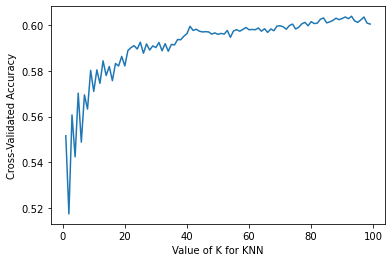

In [822]:
plt.plot(list(range(1, 100)),
         pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');

In [823]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)

Best params:  {'n_neighbors': 93, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=93)
Best score:  0.6038543897216273


## Random Forest - Best features in logistic

In [100]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

In [101]:
randomforest = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=6, random_state=51)
randomforest.fit(X, y)
randomforest.score(X,y)

0.6221905101676775

In [102]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6104925053533191 [0.62152034 0.59796574 0.6108137  0.58297645 0.6391863 ]


In [103]:
randomforest.feature_importances_

array([0.22069359, 0.02471824, 0.02899195, 0.07864156, 0.03667276,
       0.07135158, 0.02374492, 0.03514919, 0.02991253, 0.04182099,
       0.20405635, 0.0999787 , 0.03186349, 0.03503993, 0.03736421])

<AxesSubplot:ylabel='feature'>

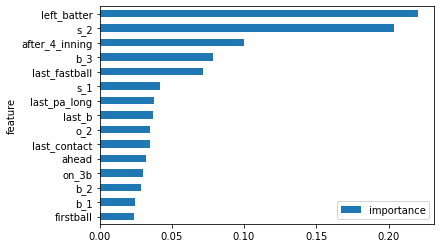

In [104]:
feat_imps = list(zip(X.columns,randomforest.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')

In [105]:
rfc = RandomForestClassifier() 
param_grid = {'n_estimators': list(range(50,551,100)),
              'max_features': ['sqrt', 'log2'],
              'max_depth': list(range(2,10,1)),
              'random_state': [51]}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=tscv, n_jobs=-2)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 150, 'random_state': 51}
0.6104925053533191


## Random Forest - try different features

In [522]:
df_train_scaled.columns

Index(['fastball', 'b_score', 'p_score', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'inning', 'left_batter', 'top',
       'day_game', 'b_0', 'b_1', 'b_2', 'b_3', 's_0', 's_1', 's_2', 'o_0',
       'o_1', 'o_2', 'inning_sq_root', 'after_4_inning', 'after_5_inning',
       'firstball', 'first2ball', 'abs_diff', 'diff', 'tie', 'ahead', 'behind',
       'tempature', 'more_than_70', 'last_fastball', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_run', 'last_in_play_out',
       'last_num', 'game_pitch', 'last_over_9', 'over_30_pitches',
       'last_pa_homerun', 'last_pa_double_triple', 'last_pa_long',
       'last_pa_so', 'last_pa_bb', 'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [203]:
X = df_train_scaled[['on_1b', 'on_2b', 'on_3b', 'left_batter', 'top',
       'day_game', 'b_0', 'b_1', 'b_2', 'b_3', 's_0', 's_1', 's_2', 'o_0',
       'o_1', 'o_2', 'after_4_inning', 'after_5_inning',
       'firstball', 'first2ball', 'tie', 'ahead', 'behind',
       'more_than_70', 'last_fastball', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_run', 'last_in_play_out',
       'last_over_9', 'over_30_pitches',
       'last_pa_homerun', 'last_pa_double_triple', 'last_pa_long',
       'last_pa_so', 'last_pa_bb', 'last_pa_dp', 'last_pa_out']]
y = df_train_scaled['fastball']

In [204]:
randomforest = RandomForestClassifier(n_estimators=250, max_features='log2', max_depth=7, random_state=51)
randomforest.fit(X, y)
randomforest.score(X,y)

0.6358366036389582

In [205]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.608779443254818 [0.61777302 0.59582441 0.61295503 0.57494647 0.64239829]


In [206]:
randomforest.feature_importances_

array([0.01815267, 0.02936238, 0.01780848, 0.13409881, 0.01890966,
       0.01803017, 0.018461  , 0.01888563, 0.01597376, 0.04531297,
       0.04101759, 0.03445368, 0.10335276, 0.01561404, 0.01437349,
       0.02046583, 0.04400232, 0.02855121, 0.01056206, 0.02830463,
       0.01918189, 0.01687521, 0.0136992 , 0.01630186, 0.04681252,
       0.0157016 , 0.01797972, 0.00869748, 0.02447541, 0.00334666,
       0.00379122, 0.00503917, 0.04855461, 0.01077328, 0.01349428,
       0.01427823, 0.01142865, 0.01023315, 0.00684106, 0.01680167])

<AxesSubplot:ylabel='feature'>

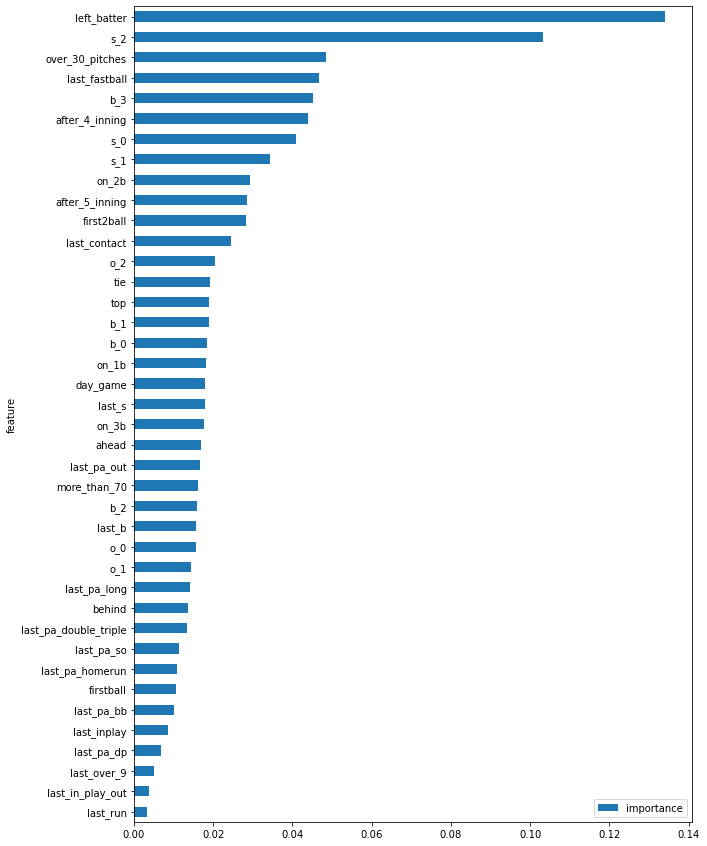

In [207]:
feat_imps = list(zip(X.columns,randomforest.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh', figsize = (10,15))

In [807]:
rfc = RandomForestClassifier() 
param_grid = {'n_estimators': list(range(50,551,100)),'max_features': ['sqrt', 'log2'],
              'max_depth': list(range(2,10,1)),
              'random_state': [51]}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=tscv, n_jobs=-2)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 250}
0.6105995717344753


## Extra Tree

In [40]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

In [58]:
et = ExtraTreesClassifier(n_estimators=350, random_state=51, max_depth=6, max_features='sqrt')
et.fit(X, y)
et.score(X,y)

0.622993221548341

In [59]:
cv_score = cross_val_score(et, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6111349036402569 [0.62473233 0.59314775 0.6124197  0.58137045 0.64400428]


In [57]:
et = ExtraTreesClassifier() 
param_grid = {'n_estimators': list(range(50,551,100)),'max_features': ['sqrt', 'log2'],
              'max_depth': list(range(2,10,1)),
              'random_state': [51]}
cv_et = GridSearchCV(estimator=et, param_grid=param_grid, cv=tscv, n_jobs=-2)
cv_et.fit(X, y)
print(cv_et.best_params_)
print(cv_et.best_score_)

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 350, 'random_state': 51}
0.6111349036402569


## XGBoost

In [283]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

xgb_cf = xgb.XGBClassifier(n_estimators=100, max_depth=2,random_state=51, learning_rate = 0.2, verbosity = 0,
                           use_label_encoder = False)
xgb_cf.fit(X,y)
xgb_cf.score(X,y)

0.6236175526221905

In [284]:
cv_score = cross_val_score(xgb_cf, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6178800856531049 [0.63008565 0.60599572 0.62633833 0.58672377 0.64025696]


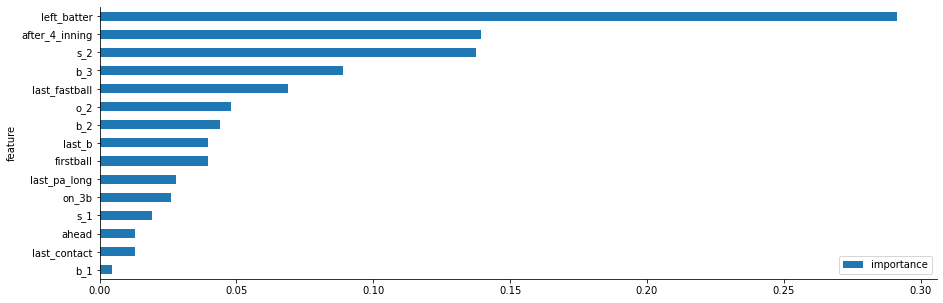

In [285]:
feat_imps = list(zip(X.columns,xgb_cf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh', figsize = (15,5))
sns.despine()
plt.savefig("images/xgboost_feature_importance.png", dpi = 400, facecolor = "w", bbox_inches="tight");

[[1328 3301]
 [ 919 5664]]


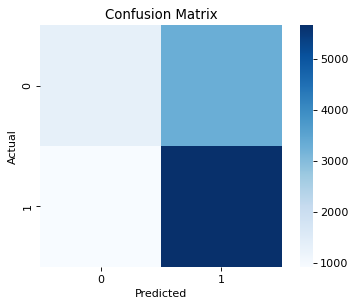

In [219]:
confusion = metrics.confusion_matrix(y, xgb_cf.predict(X))
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=False, square=True,)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

In [230]:
def time_cv(X, y, cl, p):
    sc = []
    for train_index, test_index in tscv.split(X):
        cl.fit(X.iloc[train_index], y.iloc[train_index])
        sc.append(metrics.accuracy_score(y.iloc[test_index], cl.predict_proba(X.iloc[test_index])[:,1] > p))
    return np.mean(sc)
    

In [231]:
time_cv(X, y,xgb_cf,0.5)

0.6178800856531049

In [232]:
for p in np.arange(0.3,0.7,0.01):
    print(p,time_cv(X, y,xgb_cf,p))

0.3 0.5866167023554605
0.31 0.5875802997858672
0.32 0.5894004282655245
0.33 0.5903640256959315
0.34 0.5906852248394004
0.35000000000000003 0.5910064239828693
0.36000000000000004 0.591541755888651
0.37000000000000005 0.5942184154175589
0.38000000000000006 0.5949678800856532
0.39000000000000007 0.5979657387580299
0.4000000000000001 0.6002141327623127
0.4100000000000001 0.6019271948608137
0.4200000000000001 0.603426124197002
0.4300000000000001 0.60406852248394
0.4400000000000001 0.608458244111349
0.4500000000000001 0.6115631691648822
0.46000000000000013 0.6114561027837259
0.47000000000000014 0.6147751605995718
0.48000000000000015 0.6158458244111349
0.49000000000000016 0.6145610278372591
0.5000000000000002 0.6178800856531049
0.5100000000000002 0.615845824411135
0.5200000000000002 0.6144539614561028
0.5300000000000002 0.6095289079229123
0.5400000000000003 0.60813704496788
0.5500000000000003 0.6087794432548179
0.5600000000000003 0.604710920770878
0.5700000000000003 0.604389721627409
0.580000

In [227]:
for p in np.arange(0.3,0.7,0.01):
    print(p,metrics.accuracy_score(y, xgb_cf.predict_proba(X)[:,1]>p))
    

0.3 0.5882982518729932
0.31 0.5884766321798074
0.32 0.5924009989297182
0.33 0.594987513378523
0.34 0.596414555833036
0.35000000000000003 0.5973956475205138
0.36000000000000004 0.5990902604352479
0.37000000000000005 0.6014092044238316
0.38000000000000006 0.6039957188726365
0.39000000000000007 0.6077417053157331
0.4000000000000001 0.6113093114520157
0.4100000000000001 0.614609347128077
0.4200000000000001 0.617374241883696
0.4300000000000001 0.6190688547984302
0.4400000000000001 0.6189796646450232
0.4500000000000001 0.6218337495540492
0.46000000000000013 0.6226364609347128
0.47000000000000014 0.6233499821619694
0.48000000000000015 0.6249554049232965
0.49000000000000016 0.6249554049232965
0.5000000000000002 0.6236175526221905
0.5100000000000002 0.6213877987870139
0.5200000000000002 0.6204958972529433
0.5300000000000002 0.6217445594006422
0.5400000000000003 0.618712094184802
0.5500000000000003 0.6202283267927221
0.5600000000000003 0.6188904744916162
0.5700000000000003 0.6153228683553336
0.5

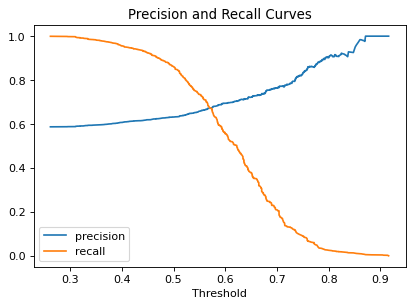

In [222]:
precision_curve, recall_curve, threshold_curve = metrics.precision_recall_curve(y, xgb_cf.predict_proba(X)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

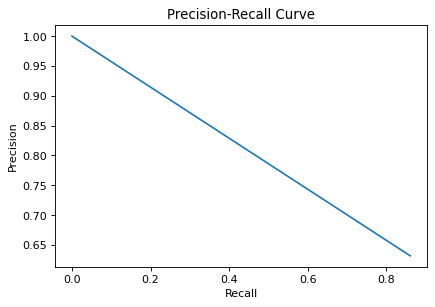

In [221]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

ROC AUC score =  0.6441645305748518


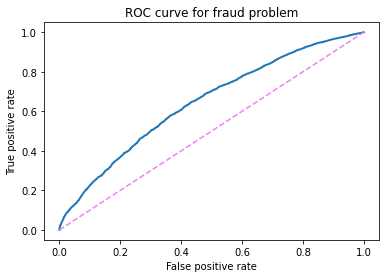

In [223]:
fpr, tpr, thresholds = metrics.roc_curve(y, xgb_cf.predict_proba(X)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", metrics.roc_auc_score(y, xgb_cf.predict_proba(X)[:,1]))

In [286]:
xgb_cf = xgb.XGBClassifier(n_estimators=1000, max_depth=6, learning_rate = 1, verbosity = 0,
                           use_label_encoder=False)
param_grid = {'n_estimators': [50,100,150],
              'max_depth': list(range(1,4,1)),
              'learning_rate': list(np.arange(0.1,0.4,0.1)), 
              'random_state': [51],
              'subsample': list(np.arange(0.4,0.9,0.1)),
              'min_child_weight': list(range(1,4,1)),
              'colsample_bytree': list(np.arange(0.5,0.8,0.1))}
CV_xbg = GridSearchCV(estimator=xgb_cf, param_grid=param_grid, cv=tscv, n_jobs=-2)
CV_xbg.fit(X,y)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=1, max_delta_step=None,
                                     max_depth=6, min_child_weight=None,...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=False,
                                     validate_parameters=None, verbosity=0),
             n_jobs=-2,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7,
                                        

In [287]:
print(CV_xbg.best_params_)
print(CV_xbg.best_score_)

{'colsample_bytree': 0.7999999999999999, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 150, 'random_state': 51, 'subsample': 0.6}
0.6174518201284797


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.p

In [60]:
X = df_train_scaled[['on_1b', 'on_2b', 'on_3b', 'left_batter', 
       'day_game',   'b_2', 'b_3', 's_0', 's_1', 's_2', 
        'o_2', 'after_4_inning', 
       'firstball',  'tie', 'behind',
         'last_b', 'last_s',
         'last_run', 
       'over_30_pitches',
       'last_pa_homerun', 'last_pa_double_triple', 
        'last_pa_bb',  'last_pa_out']]
y = df_train_scaled['fastball']
xgb_cf = xgb.XGBClassifier(n_estimators=200, max_depth=2,random_state=51, learning_rate = 0.1, verbosity = 0)
xgb_cf.fit(X,y)
xgb_cf.score(X,y)

0.6227256510881198

In [215]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

xgb_cf = xgb.XGBClassifier(n_estimators=100, max_depth=2,random_state=51, learning_rate = 0.2, verbosity = 0)
xgb_cf.fit(X,y)
xgb_cf.score(X,y)

0.6236175526221905

In [216]:
cv_score = cross_val_score(xgb_cf, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6178800856531049 [0.63008565 0.60599572 0.62633833 0.58672377 0.64025696]


<AxesSubplot:ylabel='feature'>

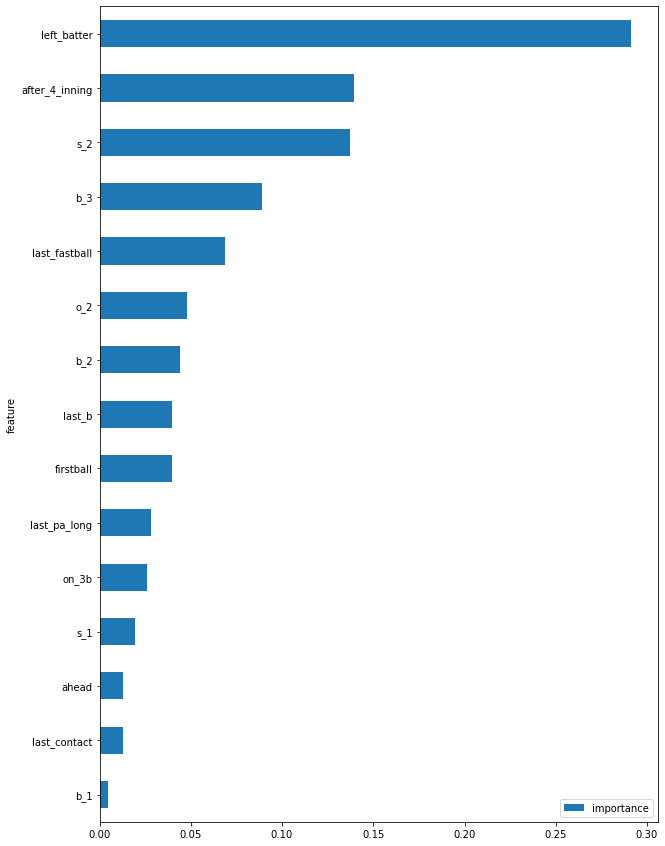

In [217]:
feat_imps = list(zip(X.columns,xgb_cf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh', figsize = (10,15))

In [61]:
cv_score = cross_val_score(xgb_cf, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6110278372591006 [0.61295503 0.59850107 0.6124197  0.59261242 0.63865096]


<AxesSubplot:ylabel='feature'>

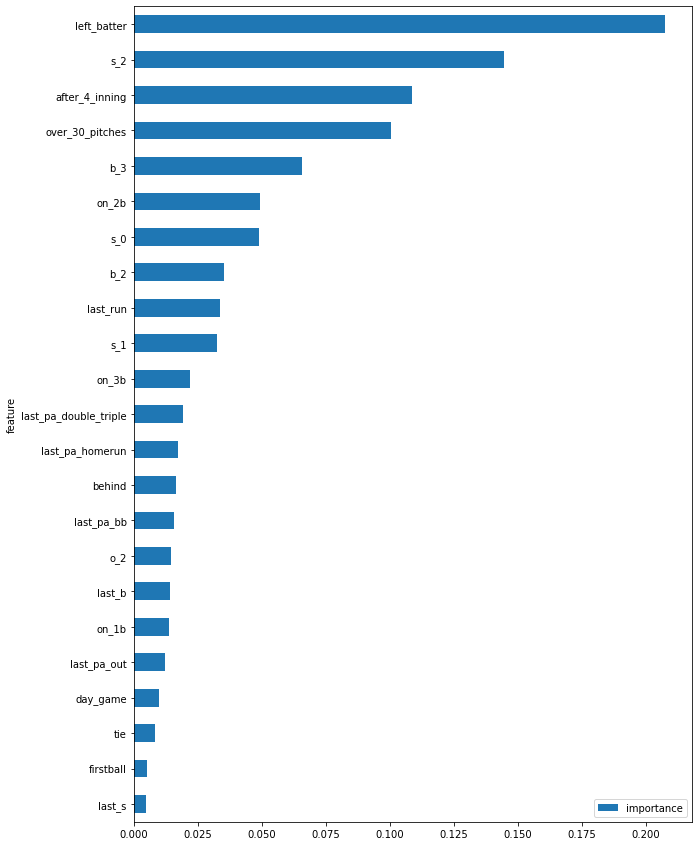

In [62]:
feat_imps = list(zip(X.columns,xgb_cf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh', figsize = (10,15))

In [289]:
xgb_cf = xgb.XGBClassifier(verbosity = 0)
param_grid = {'n_estimators': [200,300,400],'max_depth': list(range(1,4,1)),
              'learning_rate': list(np.arange(0.05,0.11,0.01)), 'random_state': [51]}
CV_xbg = GridSearchCV(estimator=xgb_cf, param_grid=param_grid, cv=tscv, n_jobs=-2)
CV_xbg.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_

In [290]:
print(CV_xbg.best_params_)
print(CV_xbg.best_score_)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'random_state': 51}
0.6159528907922912


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

## XGBoost -RF

In [146]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

xgb_rf = xgb.XGBRFClassifier(n_estimators=200, max_depth=2,random_state=51, learning_rate = 0.1, verbosity = 0)
xgb_rf.fit(X,y)
xgb_rf.score(X,y)

0.6134498751337852

In [147]:
cv_score = cross_val_score(xgb_rf, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6127408993576018 [0.62152034 0.60599572 0.60599572 0.58779443 0.64239829]


In [148]:
xgb_rf = xgb.XGBRFClassifier(n_estimators=1000, max_depth=6, learning_rate = 1, verbosity = 0)
param_grid = {'n_estimators': [100,200,300],'max_depth': list(range(1,4,1)),
              'learning_rate': list(np.arange(0.1,0.6,0.1)), 'random_state': [51]}
CV_xbg = GridSearchCV(estimator=xgb_rf, param_grid=param_grid, cv=tscv, n_jobs=-2)
CV_xbg.fit(X,y)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bytree=None, gamma=None,
                                       gpu_id=None, importance_type='gain',
                                       interaction_constraints=None,
                                       max_delta_step=None, max_depth=6,
                                       min_child_weight=None, missing=nan,
                                       monotone_constraints=None,
                                       n_estimators=1000, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None,
                                       scale_pos_weight=None, tree_me

In [149]:
print(CV_xbg.best_params_)
print(CV_xbg.best_score_)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'random_state': 51}
0.6127408993576018


In [295]:
X = df_train_scaled[['on_1b', 'on_2b', 'on_3b', 'left_batter', 'top',
       'day_game', 'b_0', 'b_1', 'b_2', 'b_3', 's_0', 's_1', 's_2', 'o_0',
       'o_1', 'o_2', 'after_4_inning', 'after_5_inning',
       'firstball', 'first2ball', 'tie', 'ahead', 'behind',
       'more_than_70', 'last_fastball', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_run', 'last_in_play_out',
       'last_over_9', 'over_30_pitches',
       'last_pa_homerun', 'last_pa_double_triple', 'last_pa_long',
       'last_pa_so', 'last_pa_bb', 'last_pa_dp', 'last_pa_out']]
y = df_train_scaled['fastball']

xgb_rf = xgb.XGBRFClassifier(n_estimators=200, max_depth=3,random_state=51, learning_rate = 0.1, verbosity = 0)
xgb_rf.fit(X,y)
xgb_rf.score(X,y)

0.614430966821263

In [296]:
cv_score = cross_val_score(xgb_rf, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6119914346895075 [0.624197   0.60117773 0.60599572 0.58779443 0.64079229]


In [293]:
xgb_rf = xgb.XGBRFClassifier(n_estimators=1000, max_depth=6, learning_rate = 1, verbosity = 0)
param_grid = {'n_estimators': [100,200,300],'max_depth': list(range(1,5,1)),
              'learning_rate': list(np.arange(0.1,0.6,0.1)), 'random_state': [51]}
CV_xbg = GridSearchCV(estimator=xgb_rf, param_grid=param_grid, cv=tscv, n_jobs=-2)
CV_xbg.fit(X,y)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bytree=None, gamma=None,
                                       gpu_id=None, importance_type='gain',
                                       interaction_constraints=None,
                                       max_delta_step=None, max_depth=6,
                                       min_child_weight=None, missing=nan,
                                       monotone_constraints=None,
                                       n_estimators=1000, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None,
                                       scale_pos_weight=None, tree_me

In [294]:
print(CV_xbg.best_params_)
print(CV_xbg.best_score_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'random_state': 51}
0.6119914346895075


## AdaBoost

In [221]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.8, random_state=51)
ada.fit(X,y)
ada.score(X,y)

0.618712094184802

In [222]:
cv_score = cross_val_score(ada, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6156316916488223 [0.62901499 0.60546039 0.61884368 0.59314775 0.63169165]


In [219]:
ada = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=51)
param_grid = {'n_estimators': [25,50,100,200,500,1000,5000],'learning_rate': np.arange(0.2,1.1,0.2),
              'random_state': [51]}
cv_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv=tscv, n_jobs=-2)
cv_ada.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=AdaBoostClassifier(learning_rate=1, random_state=51),
             n_jobs=-2,
             param_grid={'learning_rate': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                         'n_estimators': [25, 50, 100, 200, 500, 1000, 5000],
                         'random_state': [51]})

In [220]:
print(cv_ada.best_params_)
print(cv_ada.best_score_)

{'learning_rate': 0.8, 'n_estimators': 200, 'random_state': 51}
0.6156316916488223


## Naive Bayes

In [118]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

nb = BernoulliNB()
nb.fit(X,y)
nb.score(X,y)

0.6113093114520157

In [119]:
y

0        1
1        1
2        1
3        0
4        1
        ..
11207    0
11208    1
11209    0
11210    1
11211    1
Name: fastball, Length: 11212, dtype: int64

In [120]:
cv_score = cross_val_score(nb, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6014989293361885 [0.60974304 0.59957173 0.60171306 0.57655246 0.61991435]


## Soft Voting

In [269]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 
                     'o_2', 'on_3b', 'ahead',
                     's_1', 's_2', 'after_4_inning','last_contact','last_pa_long']]
y = df_train_scaled['fastball']


estimators = [
    ('xgb_cf', xgb.XGBClassifier(n_estimators=100, max_depth=2,random_state=51, learning_rate=0.2, verbosity=0)),
    #('knn', KNeighborsClassifier(n_neighbors=84)),
    #('nb', BernoulliNB()),
    #('randomforest', RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=6, random_state=51)),
    #('et', ExtraTreesClassifier(n_estimators=350, random_state=51, max_depth=6, max_features='sqrt')),
    ('ada', AdaBoostClassifier(n_estimators=200, learning_rate=0.8, random_state=51)),
    ('xgb_rf', xgb.XGBRFClassifier(n_estimators=200, max_depth=2,random_state=51, learning_rate=0.1, verbosity=0)),
    ('log_reg', LogisticRegression(C=1, penalty = 'l1', solver='liblinear'))]

voting_classifer = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-2)
voting_classifer.fit(X, y)
voting_classifer.score(X, y)

0.622993221548341

In [270]:
cv_score = cross_val_score(voting_classifer, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6145610278372591 [0.63276231 0.60278373 0.61563169 0.58137045 0.64025696]


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.

## Hard Voting

In [255]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 
                     'o_2', 'on_3b', 'ahead',
                     's_1', 's_2', 'after_4_inning','last_contact','last_pa_long']]
y = df_train_scaled['fastball']


estimators = [
    ('xgb_cf', xgb.XGBClassifier(n_estimators=100, max_depth=2,random_state=51, learning_rate=0.2, verbosity=0)),
    #('knn', KNeighborsClassifier(n_neighbors=84)),
    #('nb', BernoulliNB()),
    #('randomforest', RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=6, random_state=51)),
    #('et', ExtraTreesClassifier(n_estimators=350, random_state=51, max_depth=6, max_features='sqrt')),
    ('ada', AdaBoostClassifier(n_estimators=200, learning_rate=0.8, random_state=51)),
    ('xgb_rf', xgb.XGBRFClassifier(n_estimators=200, max_depth=2,random_state=51, learning_rate=0.1, verbosity=0)),
    ('log_reg', LogisticRegression(C=1, penalty = 'l1', solver='liblinear'))]

voting_classifer = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-2)
voting_classifer.fit(X, y)
voting_classifer.score(X, y)

0.6206742775597573

In [256]:
cv_score = cross_val_score(voting_classifer, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6201284796573876 [0.62955032 0.6140257  0.624197   0.59743041 0.63543897]


[[1538 3091]
 [1162 5421]]


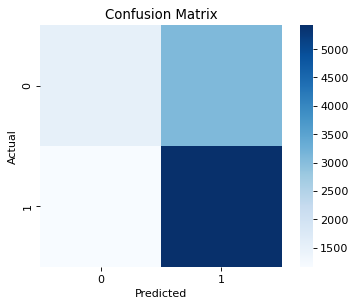

In [253]:
#confusion = metrics.confusion_matrix(y, stacked.predict(X))
confusion = metrics.confusion_matrix(y, voting_classifer.predict(X))
print(confusion)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=False, square=True,)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

## Stacking

In [210]:
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']

log_reg = LogisticRegression(C=1, penalty = 'l1', solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=84)
randomforest = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=6, random_state=51)
xgb_rf = xgb.XGBRFClassifier(n_estimators=100, max_depth=3,random_state=51, learning_rate = 1, verbosity = 0)
xgb_cf = xgb.XGBClassifier(n_estimators=100, max_depth=1,random_state=51, learning_rate = 1, verbosity = 0)
ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.8, random_state=51)
et = ExtraTreesClassifier(n_estimators=350, random_state=51, max_depth=6, max_features='sqrt')
nb = BernoulliNB()

# , knn, randomforest, et, nb, , xgb_rf
stacked = StackingClassifier(classifiers=[xgb_cf, log_reg, ada],
                             meta_classifier=LogisticRegression(), use_probas=False)


stacked.fit(X, y)
stacked.score(X,y)

0.618801284338209

In [211]:
cv_score = cross_val_score(stacked, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6163811563169166 [0.63115632 0.60492505 0.61937901 0.59314775 0.63329764]


In [50]:
#sklearn
X = df_train_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 'o_2', 'on_3b',
                     's_1', 's_2', 'after_4_inning', 'ahead','last_contact','last_pa_long']]
y = df_train_scaled['fastball']


estimators = [
    ('log_reg', LogisticRegression(C=1, penalty = 'l1', solver='liblinear')),
    ('knn', KNeighborsClassifier(n_neighbors=84)),
    ('randomforest', RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=6, random_state=51))]

stacked = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked.fit(X, y)
stacked.score(X,y)

0.6306635747413486

In [51]:
cv_score = cross_val_score(stacked, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6095289079229123 [0.62205567 0.60117773 0.6140257  0.58190578 0.62847966]


## Stacking - Other Features

In [592]:
df_train.columns

Index(['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_0', 'b_1', 'b_2',
       'b_3', 's_0', 's_1', 's_2', 'o_0', 'o_1', 'o_2', 'inning_sq_root',
       'after_4_inning', 'after_5_inning', 'firstball', 'first2ball',
       'abs_diff', 'diff', 'tie', 'ahead', 'behind', 'tempature',
       'more_than_70', 'last_pitch_type', 'last_fastball', 'last_code',
       'last_type', 'last_b', 'last_s', 'last_inplay', 'last_contact',
       'last_pitch', 'last_run', 'last_in_play_out', 'last_pa', 'last_num',
       'game_pitch', 'last_over_9', 'over_30_pitches', 'last_pa_homerun',
       'last_pa_double_triple', 'last_pa_long', 'last_pa_so', 'last_pa_bb',
       'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [826]:
X = df_train_scaled[['left_batter', 's_1', 's_2','b_1', 'b_2', 'b_3', 'ahead','last_in_play_out',
                     'last_s','last_run','last_fastball','firstball', 'o_2','last_pa_long',
                     'on_2b', 'on_3b','first2ball','more_than_70', 'day_game','inning_sq_root']]
y = df_train_scaled['fastball']

log_reg = LogisticRegression(C=1, penalty = 'l1', solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=93)
randomforest = RandomForestClassifier(n_estimators=250, max_features='log2', max_depth=7)

stacked = StackingClassifier(classifiers=[log_reg, knn, randomforest],
                             meta_classifier=LogisticRegression(), use_probas=False)


stacked.fit(X, y)

StackingClassifier(classifiers=[LogisticRegression(C=1, penalty='l1',
                                                   solver='liblinear'),
                                KNeighborsClassifier(n_neighbors=93),
                                RandomForestClassifier(max_depth=7,
                                                       max_features='log2',
                                                       n_estimators=250)],
                   meta_classifier=LogisticRegression())

In [827]:
cv_score = cross_val_score(stacked, X, y,cv=tscv, scoring='accuracy')
print(cv_score.mean(), cv_score)

0.6047109207708778 [0.6124197  0.58832976 0.61134904 0.5754818  0.6359743 ]


## test

In [268]:
df_test['fastball'].mean()

0.5798394290811775

In [264]:
X_t = df_test_scaled[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','firstball', 
                     'o_2', 'on_3b', 'ahead',
                     's_1', 's_2', 'after_4_inning','last_contact','last_pa_long']]
y_t = df_test_scaled['fastball']
metrics.accuracy_score(y_t, voting_classifer.predict(X_t))

0.6074933095450491

In [265]:
metrics.confusion_matrix(y_t, voting_classifer.predict(X_t))

array([[ 299,  643],
       [ 237, 1063]])

In [266]:
metrics.confusion_matrix(y_t, voting_classifer.predict(X_t))/len(y_t)

array([[0.13336307, 0.2867975 ],
       [0.10570919, 0.47413024]])

In [267]:
len(y_t)

2242

## Other

In [1543]:
for train_index, test_index in tscv.split(df_clean):
    print(train_index, test_index)

[   0    1    2 ... 2241 2242 2243] [2244 2245 2246 ... 4483 4484 4485]
[   0    1    2 ... 4483 4484 4485] [4486 4487 4488 ... 6725 6726 6727]
[   0    1    2 ... 6725 6726 6727] [6728 6729 6730 ... 8967 8968 8969]
[   0    1    2 ... 8967 8968 8969] [ 8970  8971  8972 ... 11209 11210 11211]
[    0     1     2 ... 11209 11210 11211] [11212 11213 11214 ... 13451 13452 13453]


In [1572]:
df_train_weighted = pd.concat([df_train.iloc[range(0,2244)],
                                df_train.iloc[range(2244,4486)], df_train.iloc[range(2244,4486)],
                                df_train.iloc[range(4486,6728)], df_train.iloc[range(4486,6728)], df_train.iloc[range(4486,6728)],
                                df_train.iloc[range(6728,8970)], df_train.iloc[range(6728,8970)],
                                df_train.iloc[range(6728,8970)], df_train.iloc[range(6728,8970)]])
df_train_weighted.sort_values(by = ['ab_id', 'pitch_num'], inplace = True)
df_train_weighted

,pitch_type,fastball,start_speed,zone,code,type,b_score,p_score,ab_id,pitch_num,...,game_pitch,last_over_8,over_30_pitches,last_pa_homerun,last_pa_double_triple,last_pa_long,last_pa_so,last_pa_bb,last_pa_dp,last_pa_out
0,FF,1,90.6,13.0,C,S,0,0,2015000632,1,...,0,0,0,0,0,0,1,0,0,1
1,FF,1,93.5,11.0,F,S,0,0,2015000632,2,...,0,0,0,0,0,0,1,0,0,1
2,FF,1,94.9,11.0,B,B,0,0,2015000632,3,...,0,0,0,0,0,0,1,0,0,1
3,CH,0,86.6,14.0,B,B,0,0,2015000632,4,...,0,0,0,0,0,0,1,0,0,1
4,FF,1,94.0,11.0,B,B,0,0,2015000632,5,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9002,FT,1,92.4,11.0,B,B,5,0,2017110216,1,...,55,0,1,0,0,0,0,0,0,1
9003,CU,0,76.0,1.0,F,S,5,0,2017110216,2,...,55,0,1,0,0,0,0,0,0,1
9003,CU,0,76.0,1.0,F,S,5,0,2017110216,2,...,55,0,1,0,0,0,0,0,0,1
9003,CU,0,76.0,1.0,F,S,5,0,2017110216,2,...,55,0,1,0,0,0,0,0,0,1


In [1366]:
def class_cv(X_score, y_score, cv_score, mertic_score):
    '''
    A function to run scores on classificaiton models
    Slow on KNN and RandomForestClassifier
    '''
    scaler_s = StandardScaler()
    X_scaled_s = scaler_s.fit_transform(X_score)
    
    log_reg_s = LogisticRegression(penalty='none')
    cv_score_log = cross_val_score(log_reg_s, X_score, y_score, cv=cv_score, scoring=mertic_score)
    print('Logistic Regression without peanlty:', cv_score_log, cv_score_log.mean())
    
    log_grid_s = GridSearchCV(log_reg_s, 
                              param_grid={'C':[0.001,0.01,0.1,1,10,100,1000,10000],'penalty': ['l1','l2','none'],
                                          'solver': ['liblinear']}, 
                              cv=cv_score, scoring=mertic_score)
    log_grid_s.fit(X_scaled_s, y_score)
    print('Logistic Regression grid search:', log_grid_s.best_score_, log_grid_s.best_params_)
    
    knn_s = KNeighborsClassifier()
    knn_grid_s = GridSearchCV(knn_s, 
                              param_grid={'n_neighbors': list(range(1, 100)),
                                          'weights': ['uniform', 'distance']},
                              cv=cv_score, scoring=mertic_score)
    knn_grid_s.fit(X_scaled_s, y_score)
    print('KNN grid search:', knn_grid_s.best_score_, knn_grid_s.best_params_)
    
    rfc_s = RandomForestClassifier() 
    rfc_grid_s = GridSearchCV(rfc_s, 
                          param_grid={'n_estimators': list(range(50,501,50)),
                                      'max_features': ['sqrt', 'log2']}, 
                          cv=cv_score, scoring=mertic_score)
    rfc_grid_s.fit(X_score, y_score)
    print('RandomForestClassifier grid search:', rfc_grid_s.best_score_, rfc_grid_s.best_params_)
    pass
    

In [1365]:
X = df_train[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball',
              's_1', 's_2', 'after_4_inning', 'last_contact','day_game', 'last_pa_so','ahead','last_pa_long']]
y = df_train['fastball']
class_cv(X, y, tscv, 'accuracy')

Logistic Regression without peanlty: [0.63008565 0.60171306 0.62152034 0.58672377 0.62740899] 0.6134903640256959
Logistic Regression grid search: 0.6137044967880086 {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
KNN grid search: 0.6039614561027837 {'n_neighbors': 68, 'weights': 'uniform'}
RandomForestClassifier grid search: 0.5808351177730193 {'max_features': 'sqrt', 'n_estimators': 450}


In [1542]:
X = df_train[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball',
              's_1', 's_2', 'after_4_inning', 'last_contact','day_game', 'last_pa_so','ahead','last_pa_long']]
y = df_train['fastball']
class_cv(X, y, 5, 'accuracy')

Logistic Regression without peanlty: [0.62104325 0.59741418 0.6235504  0.61552186 0.60080285] 0.6116665069203305
Logistic Regression grid search: 0.6130934858095539 {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
KNN grid search: 0.6093463537865649 {'n_neighbors': 89, 'weights': 'uniform'}
RandomForestClassifier grid search: 0.5842845001378061 {'max_features': 'log2', 'n_estimators': 450}
